In [12]:
import os
import cv2
import pandas as pd
import torch
from PIL import Image
from torch import nn
from functools import partial
from finetune.convnext import convnext_tiny
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from itertools import combinations
from math import factorial
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM
import gc
from collections import  defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:



class CAM(GradCAM):
    def forward(self, input_tensor, targets, eigen_smooth= False):
        input_tensor = input_tensor.to(self.device)

        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor, requires_grad=True)

        self.outputs = outputs = self.activations_and_grads(input_tensor)

        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output) for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=False)

        cam_per_layer = self.compute_cam_per_layer(input_tensor, targets, eigen_smooth)
        return self.aggregate_multi_layers(cam_per_layer)

def visualize_score(visualization, name):

    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 1, cv2.LINE_AA)
    return visualization

def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      mask_roi:np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET,
                      image_weight: float = 0.5) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.

    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    :returns: The default image with the cam overlay.
    """
    #mask[(img[:,:,0]*255<10) & (img[:,:,1]*255<10)& (img[:,:,2]*255<10)]=0
    #mask[mask<0.27]=0
    #mask_roi=None
    mask[mask_roi==0]=np.min(mask)
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    # if mask_roi is not None:
    #     heatmap = cv2.bitwise_and(heatmap, heatmap, mask=mask_roi)
    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1].\
                Got: {image_weight}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    #cam[(img[:, :, 0] * 255 < 10) & (img[:, :, 1] * 255 < 10) & (img[:, :, 2] * 255 < 10)] = 0
    return np.uint8(255 * cam)



def benchmark(model,input_tensor,ori_img, target_layers,model_name='FULL', eigen_smooth=False, aug_smooth=False, category=1,mask_roi=None):

    methods = [(model_name, CAM(model=model, target_layers=target_layers))]

    targets = [ClassifierOutputTarget(category=category)]

    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)

        attribution = attributions[0, :]
        output = cam_method.outputs
        image_pro = torch.softmax(output, dim=-1).squeeze(0)
        #attribution[(ori_img[:, :, 0] * 255 < 10) & (ori_img[:, :, 1] * 255 < 10) & (ori_img[:, :, 2] * 255 < 10)] = 0
        visualization = show_cam_on_image(ori_img, attribution,mask_roi, use_rgb=True)
        visualization = visualize_score(visualization, name)

    del  input_tensor,output,attributions
    torch.cuda.empty_cache()
    gc.collect()
    return visualization,image_pro,attribution

def creatMask(Image, threshold = 10,img_type='full'):
    ##This program try to creat the mask for the filed-of-view
    ##Input original image (RGB or green channel), threshold (user set parameter, default 10)
    ##Output: the filed-of-view mask

    if len(Image.shape) == 3: ##RGB image
        gray = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
        Mask0 = gray >= threshold

    else:  #for green channel image
        Mask0 = Image >= threshold


    # ######get the largest blob, this takes 0.18s
    cvVersion = int(cv2.__version__.split('.')[0])
    Mask0 = np.uint8(Mask0)
    if img_type!='full':
        return  Mask0
    contours, hierarchy = cv2.findContours(Mask0, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    areas = [cv2.contourArea(c) for c in contours]
    max_index = np.argmax(areas)
    Mask = np.zeros(Image.shape[:2], dtype=np.uint8)
    cv2.drawContours(Mask, contours, max_index, 1, -1)

    return Mask
def calculate_shapley_value_single(predictions):
    """
    计算特定特征的Shapley值
    :param predictions: 预测值字典，其中键是特征组合，值是模型预测值
    :param all_features: 所有特征的索引列表
    :return: 特征的Shapley值
    """
    all_features = [0,1,2]
    num_features = len(all_features)

    shapley_values = [0.0,0.0,0.0]
    for feature in all_features:
        shapley_value = 0.0
        for subset_size in range(num_features):
            for subset in combinations(all_features, subset_size):
                if feature in subset:
                    continue
                subset_with_feature = tuple(sorted(subset + (feature,)))
                subset_without_feature = tuple(sorted(subset))
                f_subset_with = predictions.get(subset_with_feature, 0)
                f_subset_without = predictions.get(subset_without_feature, 0)
                # 计算Shapley值的贡献
                coefficient = factorial(len(subset)) * factorial(num_features - len(subset) - 1) / factorial(num_features)
                shapley_value += coefficient * (f_subset_with - f_subset_without)
        shapley_values[feature] = shapley_value.item()
    return shapley_values
def normalize_attr(attr):
    if np.min(attr)!=np.max(attr):
        attr = (attr - np.min(attr)) / (
                    np.max(attr) - np.min(attr))
    else:
        attr = np.zeros_like(attr)
    return attr

class LayerNorm2d(nn.LayerNorm):
    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        x = x.permute(0, 3, 1, 2).contiguous()
        return x
class MultiAV_RIP(nn.Module):
    def __init__(self,
                 num_classes=2,pretrain=True,drop_path=0.1
                 ):

        super(MultiAV_RIP, self).__init__()
        self.num_classes = num_classes

        cut = 6
        base_model = convnext_tiny
        norm_layer = partial(LayerNorm2d, eps=1e-6)
        if pretrain:

            layers = list(base_model(stochastic_depth_prob=drop_path).features)[:cut]
        else:
            layers = list(base_model(stochastic_depth_prob=drop_path).features)[:cut]

        base_layers = nn.Sequential(*layers)
        self.sn_unet = base_layers

        #self.avg = GeM(2)
        self.avg = nn.AdaptiveAvgPool2d(1)
        # self.final = nn.Sequential(nn.Conv2d(384*2, self.num_classes, kernel_size=(1, 1), stride=(1, 1), bias=False),nn.Flatten(1))
        if pretrain:

            self.head = nn.Sequential(norm_layer(384),nn.Flatten(1), nn.Linear(384, 384),nn.BatchNorm1d(384),nn.GELU(), nn.Linear(384, self.num_classes))
            #self.head = nn.Sequential(nn.LayerNorm(384), nn.GELU(),nn.Linear(384, self.num_classes))
        else:

            self.head = nn.Sequential(norm_layer(384),nn.Flatten(1), nn.Linear(384, 384),nn.BatchNorm1d(384),nn.GELU(), nn.Linear(384, self.num_classes))
        if not pretrain:
            print("===============train from scratch================")
            self.apply(self._init_weights)

    def _init_weights(self, m):
       if isinstance(m, (nn.Conv2d, nn.Linear)):
           nn.init.trunc_normal_(m.weight, std=.02)
           #nn.init.trunc_normal_(m.weight, std=2e-5)
           nn.init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.sn_unet(x)
        if len(x.shape) == 4 and x.shape[2] != x.shape[3]:
            B, H, W, C = x.shape
            x = x.permute(0, 3, 1, 2).contiguous()
        elif len(x.shape) == 3:
            B, L, C = x.shape
            h = int(L ** 0.5)
            x = x.view(B, h, h, C)
            x = x.permute(0, 3, 1, 2).contiguous()
        else:
            B, C,H, W = x.shape
            x = x

        x = self.avg(x)
        #x = x.view(B,-1)

        high_out = self.head(x)

        return high_out

class Crop2Rec(object):
    def __call__(self,img):
        image = np.array(img)
        height, width = image.shape[:2]
        if height > width:
            left = 0
            right = width
            top = (height - width) // 2
            bottom = top + width
        else:
            top = 0
            bottom = height
            left = (width - height) // 2
            right = left + height
        image = image[top:bottom, left:right]
        return Image.fromarray(image)

class model:
    def __init__(self):
        self.model = MultiAV_RIP(
            num_classes=2
        )
        #self.checkpoint = "train_best_acc_model_drive_2024-07-03-01-42.pth"
        self.checkpoint = "checkpoint-best.pth"
        self.device = torch.device("cuda")

    def load(self, dir_path):
        checkpoint_path = os.path.join(dir_path)
        checkpoint_model = torch.load(checkpoint_path, map_location=self.device)

        model_static = self.model.state_dict()
        pt_ = {k: v for k, v in checkpoint_model.items() if k in model_static}
        model_static.update(pt_)
        self.model.load_state_dict(pt_)
        #torch.save(self.model.state_dict(),'scrath_stu_all.pkl')
        self.model.to(self.device)

    def transform(self,input_image):
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        # image = Image.fromarray(input_image)

        # crop_pct = 224 / 256
        # size = int(256 / crop_pct)
        # size=256
        t1 = transforms.Compose([
            #Crop2Rec(),
            transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(512),

        ])
        transform2 = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean, std)])
        image = t1(input_image)
        # image = np.array(image) / 255
        # image = methods.brighten_darken(image, 'A+C+X+Z')
        # image = map_to_0_255(image)
        # image = Image.fromarray(np.uint8(map_to_0_255(image)))
        image_c = image.copy()
        image = transform2(image)
        image = image.type(torch.FloatTensor)
        image = torch.unsqueeze(image, 0)
        # image = cv2.resize(input_image, (224, 224))
        # image = image / 255
        # image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
        # image = image.to(self.device, torch.float)
        return image, np.float32(image_c) / 255

    def predict(self, input_image):
        self.model.eval()
        image,ori = self.transform(input_image)
        with torch.no_grad():
            output = self.model(image.to(self.device))
            prob = torch.softmax(output,dim=-1).squeeze(0)
            score,index=torch.max(prob,-1)

        class_1_prob = prob[0]
        class_2_prob = prob[1]
        class_1_prob = class_1_prob.detach().cpu()
        class_2_prob = class_2_prob.detach().cpu()

        # return 1-index,float(class_1_prob)
        return float(class_1_prob),float(class_2_prob),output[0][0].item(),output[0][1].item()



# HR explainale image

img00346.jpg
shapley_values of artery, vein, non-vascular is [0.38545605540275574, 0.5244022011756897, 0.09014176577329636]


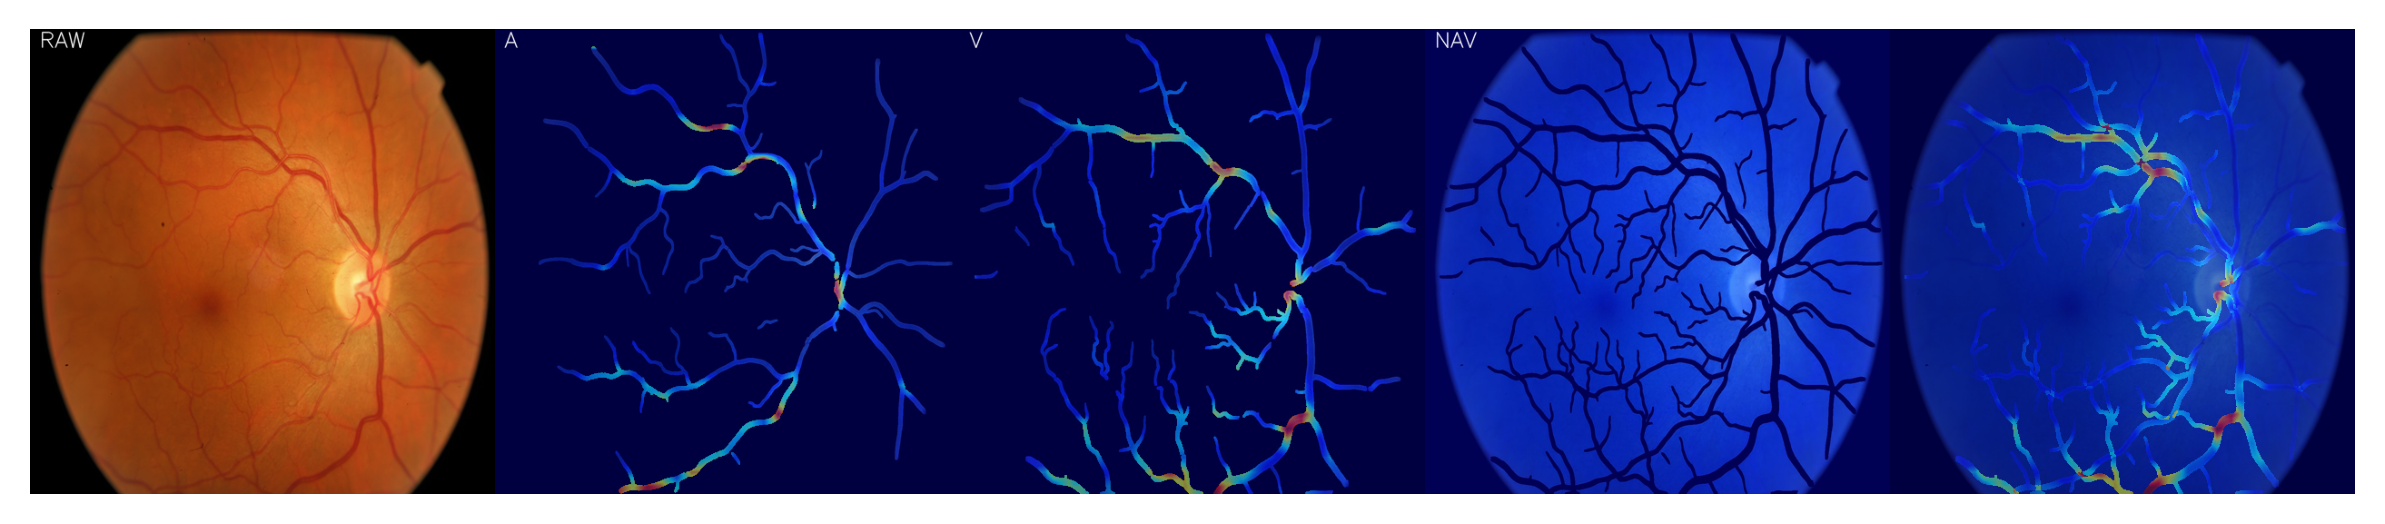

In [14]:
predictions = {}
models_dict = {}
vis = []
category = 1
shape_value_df = defaultdict(list)

img_dir = r'reproduction/explain_example/hr/img'
av_dir = r'reproduction/explain_example/hr'
# # full
select_model = model()

for img_name in os.listdir(img_dir):
    img_name_prefix = img_name.split('.')[0]
    
    if 'img00346' not in img_name:
        continue
    print(img_name)
    #img_label = Image.open(label_path)
    vis = []
    full_path = r'reproduction/weight/HR_full_checkpoint.pth'

    target_layers = [select_model.model.sn_unet[-1]]
    select_model.load(full_path)
    #img_path = os.path.join(r'D:\su-lab\dataset\retfond_green\cam\cam_HR',img_name)
    img_path = os.path.join(img_dir,img_name)
    image = Image.open(img_path)
    h,w = np.array(image).shape[0:2]
    input_tensor,img_full = select_model.transform(image)
    mask_roi = creatMask(np.uint8(img_full*255))
    cam_single_full, image_full_pro,attribution012= benchmark(select_model.model,input_tensor,img_full,target_layers,category=category,model_name='FULL',eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)
    #vis.append(cam_single)
    predictions[(0,1,2)]=1
    

    a_path = r'reproduction/weight/HR_a_checkpoint.pth'
    select_model.load(a_path)
    img_path = os.path.join(av_dir,'img_a',img_name)
    image = Image.open(img_path)
    input_tensor,img_a = select_model.transform(image)
    mask_roi_a = creatMask(np.uint8(img_a*255),img_type='av')
    cam_single, image_a_pro,attribution0= benchmark(select_model.model,input_tensor,img_a,target_layers,category=category,model_name='A',eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)

    #vis.append(cam_single)
    predictions[(0,)]=image_a_pro[category]
    v_path = r'reproduction/weight/HR_v_checkpoint.pth'
    select_model.load(v_path)
    img_path = os.path.join(av_dir,'img_v',img_name)
    image = Image.open(img_path)
    input_tensor,img_v = select_model.transform(image)
    mask_roi_v = creatMask(np.uint8(img_v*255),img_type='av')
    cam_single, image_v_pro,attribution1= benchmark(select_model.model,input_tensor,img_v,target_layers,category=category,model_name='V',eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)
    #vis.append(cam_single)
    predictions[(1,)]=image_v_pro[category]
    av_path = r'reproduction/weight/HR_av_checkpoint.pth'
    select_model.load(av_path)
    img_path = os.path.join(av_dir,'img_av',img_name)
    image = Image.open(img_path)
    input_tensor,img_av = select_model.transform(image)
    mask_roi_av = creatMask(np.uint8(img_av*255),img_type='av')
    cam_single, image_av_pro,attribution01= benchmark(select_model.model,input_tensor,img_av,target_layers,model_name='AV',category=category,eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)
    #vis.append(cam_single)
    predictions[(0,1)]=image_av_pro[category]
    na_path = r'reproduction/weight/HR_na_checkpoint.pth'
    select_model.load(na_path)
    img_path = os.path.join(av_dir,'img_na',img_name)
    image = Image.open(img_path)
    input_tensor,img = select_model.transform(image)
    mask_roi_na = creatMask(np.uint8(img*255),img_type='nav')
    cam_single, image_na_pro,attribution12= benchmark(select_model.model,input_tensor,img,target_layers,model_name='NA',category=category,eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)
    #vis.append(cam_single)
    predictions[(1,2)]=image_na_pro[category]
    
    nv_path = r'reproduction/weight/HR_nv_checkpoint.pth'
    select_model.load(nv_path)
    img_path = os.path.join(av_dir,'img_nv',img_name)
    image = Image.open(img_path)
    input_tensor,img = select_model.transform(image)
    mask_roi_nv = creatMask(np.uint8(img*255),img_type='nav')
    cam_single, image_nv_pro,attribution02= benchmark(select_model.model,input_tensor,img,target_layers,model_name='NV',category=category,eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)
    #vis.append(cam_single)
    predictions[(0,2)]=image_nv_pro[category]
    # predictions_no_softmax[(0,2)]=image_pro[3]
    #
    nav_path = r'reproduction/weight/HR_nav_checkpoint.pth'
    select_model.load(nav_path)
    img_path = os.path.join(av_dir,'img_nav',img_name)
    image = Image.open(img_path)
    input_tensor,img_n = select_model.transform(image)
    mask_roi_nav = creatMask(np.uint8(img_n*255),img_type='nav')
    #mask_roi_n = creatMask(np.uint8(img*255))
    cam_single, image_nav_pro,attribution2= benchmark(select_model.model,input_tensor,img_n,target_layers,model_name='NAV',category=category,eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)
    #vis.append(cam_single)
    predictions[(2,)]=image_nav_pro[category]
    

    shapley_values =  calculate_shapley_value_single(predictions)


    attribution_zero = np.zeros_like(attribution012)

    attribution0 =  attribution0 if image_a_pro[category] > 0.5 else attribution_zero
    attribution1 =  attribution1 if image_v_pro[category] > 0.5 else attribution_zero
    attribution01 = attribution01 if image_av_pro[category] > 0.5 else attribution_zero
    attribution2 =  attribution2 if image_nav_pro[category] > 0.5 else attribution_zero
    attribution012 =  attribution012 if image_full_pro[category] > 0.5 else attribution_zero
    attribution02 = attribution02 if image_nv_pro[category] > 0.5 else attribution_zero
    attribution12 = attribution12 if image_na_pro[category] > 0.5 else attribution_zero

    attribution_a =  np.max(np.stack((attribution0,attribution01,attribution02),axis=0),axis=0)*mask_roi_a if image_a_pro[category] > 0.5 else attribution_zero
    attribution_a_fusion = np.max(np.stack((attribution0, attribution01, attribution02,attribution012), axis=0), axis=0) * mask_roi_a if (image_a_pro[category] > 0.5 or image_av_pro[category]>0.5) else attribution_zero
    attribution_v =  np.max(np.stack((attribution1,attribution12,attribution01),axis=0),axis=0)*mask_roi_v  if (image_v_pro[category] > 0.5 or image_av_pro[category]>0.5)  else attribution_zero
    attribution_v_fusion = np.max(np.stack((attribution1, attribution12, attribution01,attribution012), axis=0), axis=0) * mask_roi_v  if image_v_pro[category] > 0.5 else attribution_zero
    attribution_av = np.max(np.stack((attribution0, attribution1,attribution01,attribution12,attribution02,attribution012),axis=0),axis=0)*mask_roi_av if (image_av_pro[category] > 0.5 or image_a_pro[category]>0.5 or image_v_pro[category]>0.5) else attribution_zero
    attribution_n =  attribution2 if image_nav_pro[category] > 0.5 else attribution_zero

    attribution_n_fusion = np.max(np.stack((attribution2, attribution02, attribution12, attribution012), axis=0),
                           axis=0) * mask_roi if image_nav_pro[category] > 0.5 else attribution_zero
    # attribution_a = (attribution0*shapley_values[0]+attribution01*shapley_values[0]+attribution02*shapley_values[0])*mask_roi_a
    # attribution_v = (attribution1*shapley_values[1]+attribution01*shapley_values[1]+attribution12*shapley_values[1])*mask_roi_v
    # attribution_n = (attribution2*shapley_values[2]+attribution02*shapley_values[2]+attribution12*shapley_values[2])*mask_roi_nav

    attribution_a_only = normalize_attr(attribution_a)
    attribution_v_only = normalize_attr(attribution_v)
    attribution_av = normalize_attr(attribution_av)
    visualization_a = show_cam_on_image(img_a, attribution_a_only,mask_roi_a, use_rgb=True)
    visualization_a = visualize_score(visualization_a, 'A')
    visualization_v = show_cam_on_image(img_v, attribution_v_only,mask_roi_v, use_rgb=True)
    visualization_v = visualize_score(visualization_v, 'V')
    visualization_av = show_cam_on_image(img_av, attribution_av,mask_roi_av, use_rgb=True)
    visualization_av = visualize_score(visualization_av, 'AV')
    # attribution = attribution_a*mask_roi_a+attribution_v*mask_roi_v+attribution_n*mask_roi_nav
    # attribution = (attribution-np.min(attribution))/(np.max(attribution)-np.min(attribution))
    attribution_n_only = normalize_attr(attribution_n)
    visualization_n = show_cam_on_image(img_n, attribution_n_only,mask_roi_nav, use_rgb=True)
    visualization_n = visualize_score(visualization_n, 'NAV')
    print(f'shapley_values of artery, vein, non-vascular is {shapley_values}')
    # 找到最大值
    max_value = max(shapley_values)
    if image_full_pro[category] > 0.5 and (image_a_pro[category]>0.5 or image_v_pro[category]>0.5 or image_nav_pro[category]>0.5 ):
        shape_value_df['name'].append(img_name)
        shape_value_df['shapely_value'].append(shapley_values)
    # 按比例缩放每个值，使最大值为1
    shapley_values = [num / max_value for num in shapley_values]
    attribution_a_fusion = normalize_attr(attribution_a_fusion)
    attribution_v_fusion = normalize_attr(attribution_v_fusion)
    attribution_n_fusion = normalize_attr(attribution_n_fusion)
    attribution = attribution_a_fusion*shapley_values[0]+shapley_values[1]*attribution_v_fusion+attribution_n_fusion*shapley_values[2]
    #attribution = (attribution-np.min(attribution))/(np.max(attribution)-np.min(attribution))
    attribution = np.clip(attribution, 0, 1)
    visualization = show_cam_on_image(img_full, attribution,mask_roi, use_rgb=True)
    visualization = visualize_score(visualization, '')

    visualization_raw = visualize_score(np.uint8(img_full*255), 'RAW')
    vis.append(visualization_raw)
    vis.append(visualization_a)
    vis.append(visualization_v)
    vis.append(visualization_n)
    vis.append(visualization)
    plt.figure(figsize=(10, 10),dpi=300)  
    plt.imshow(np.hstack(vis))
    plt.axis('off')  # 关闭坐标轴
    plt.show()

# DR explainable images

70f5caf5f305.png
shapley_values of artery, vein, non-vascular is [0.33613142371177673, 0.33269721269607544, 0.3311713933944702]


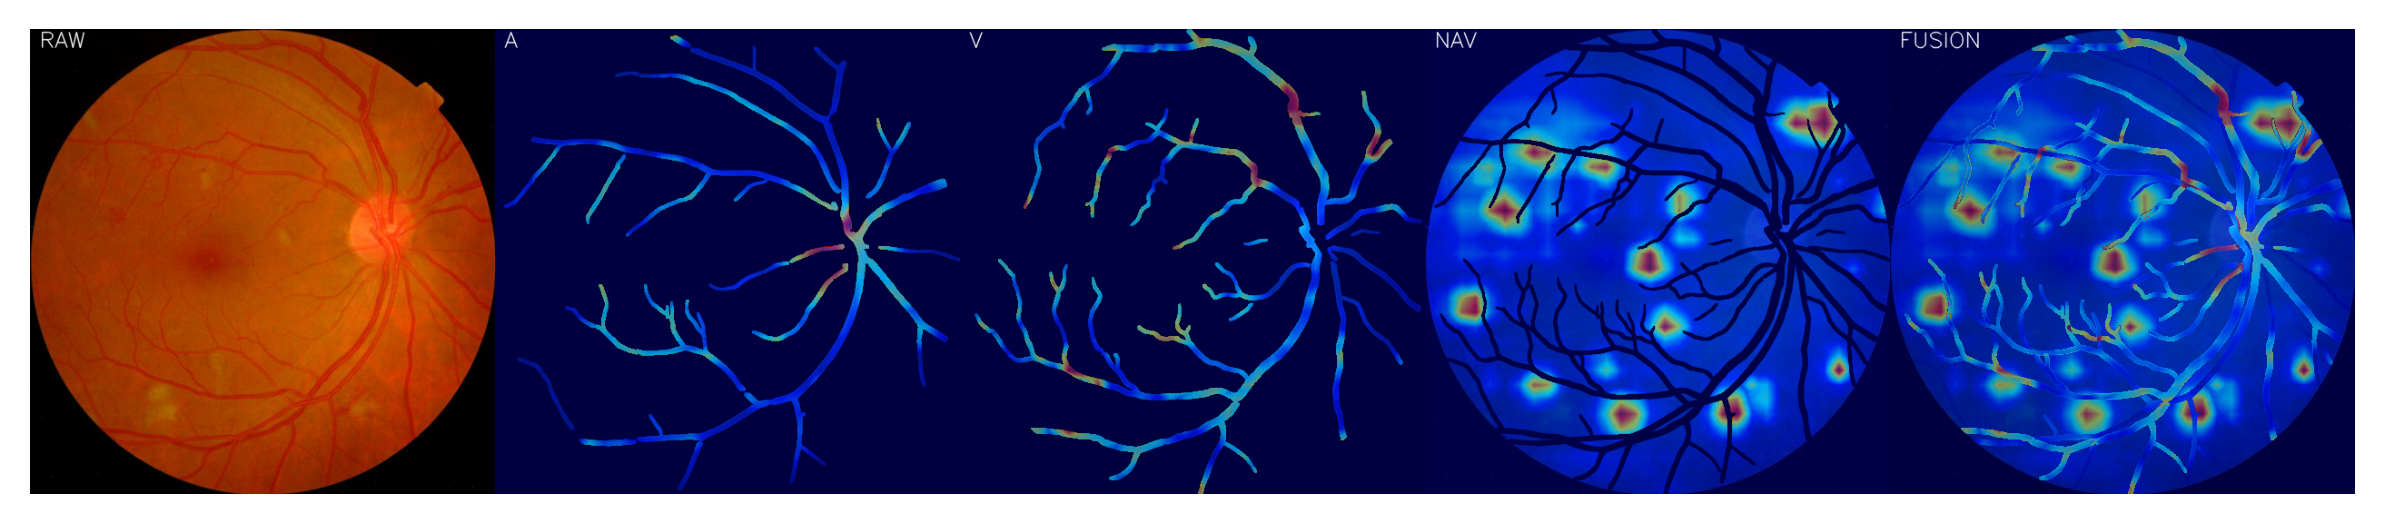

dr_mild.png
shapley_values of artery, vein, non-vascular is [0.3305099308490753, 0.32285749912261963, 0.34663259983062744]


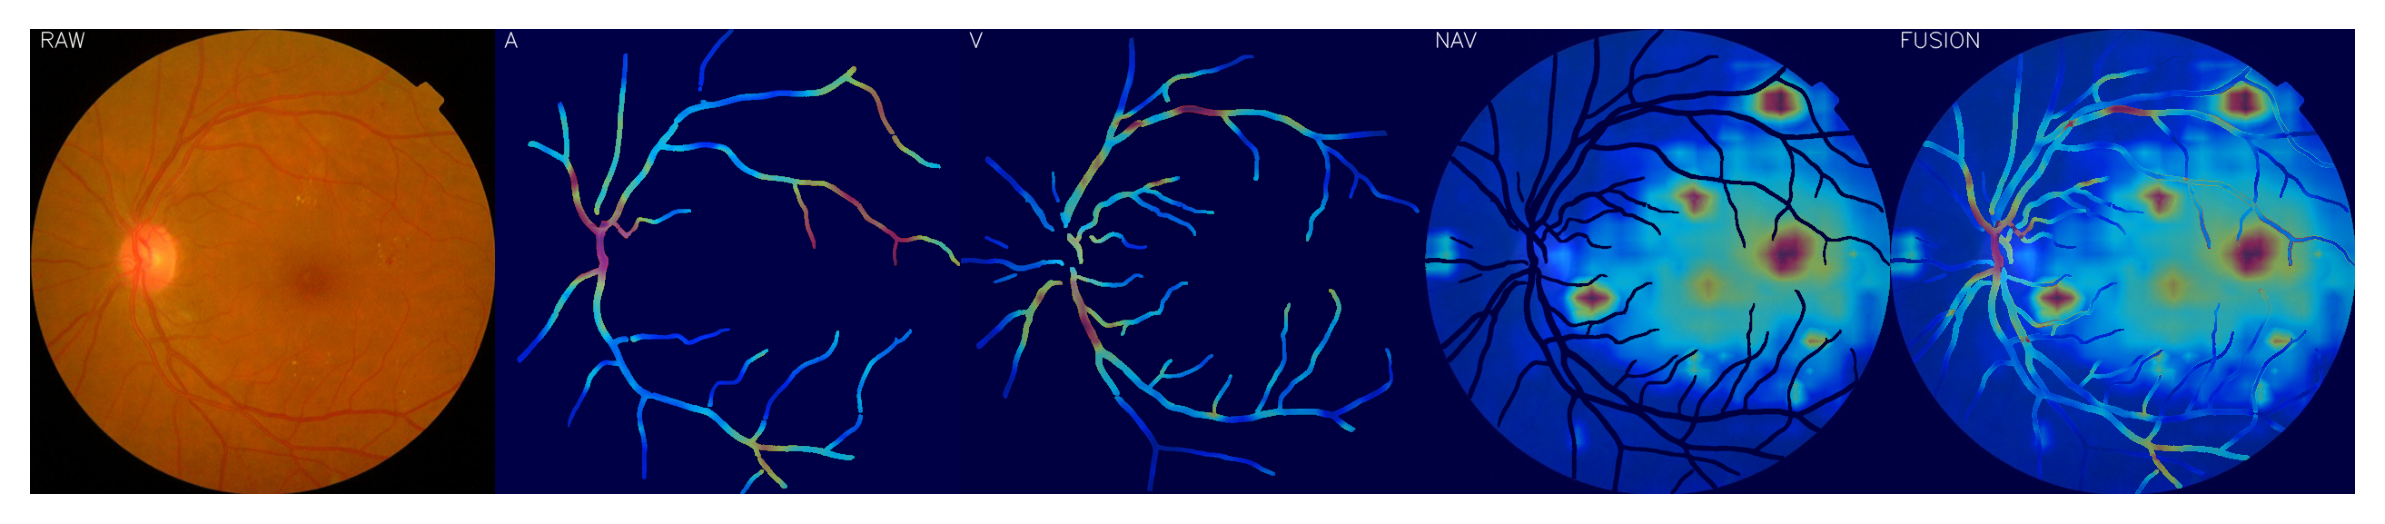

mess_se.png
shapley_values of artery, vein, non-vascular is [0.3836870789527893, 0.14273175597190857, 0.4735811650753021]


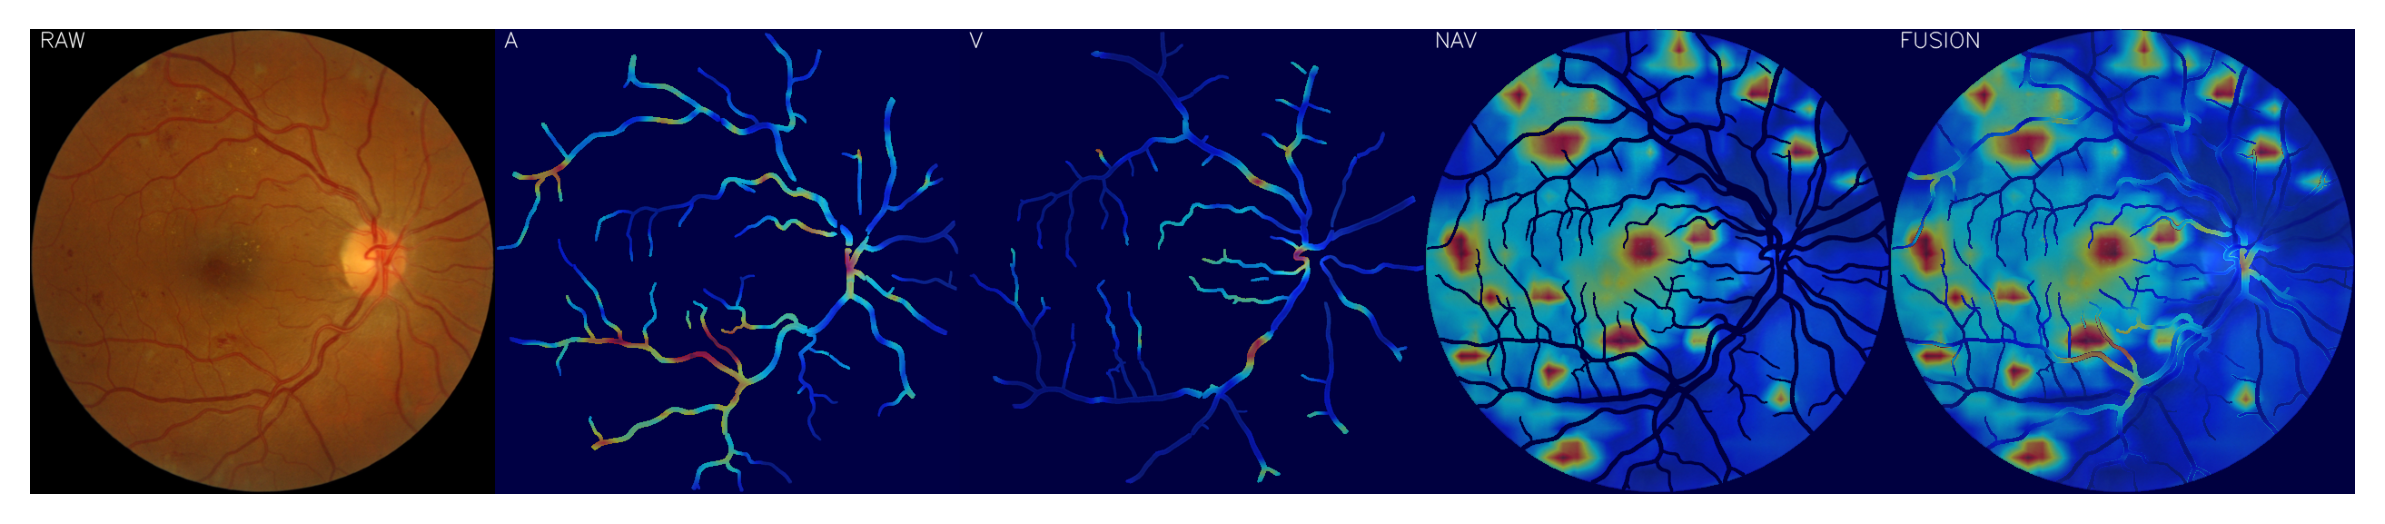

In [15]:
predictions = {}
predictions_ac = {}
predictions_ad = {}
predictions_ae = {}
models_dict = {}
vis = []
category = 1
shape_value_df = defaultdict(list)

# img_dir = r'D:\su-lab\dataset\retfond_green\cam\idrid_seg\images'
# av_dir = r'D:\su-lab\dataset\retfond_green\cam\idrid_seg\cam_DR_av_gen'
img_dir = r'reproduction/explain_example/dr/img'
av_dir = r'reproduction/explain_example/dr'

# # full
#dr_mild.png
#70f5caf5f305.png
#mess_se.png
select_model = model()
for img_name in os.listdir(img_dir):
    
    if img_name!='dr_mild.png' and img_name!='70f5caf5f305.png' and img_name!='mess_se.png':
        continue
    print(img_name)
    vis = []
    full_path = r'reproduction/weight/MESS_full_checkpoint.pth'
    target_layers = [select_model.model.sn_unet[-1]]
    select_model.load(full_path)
    #img_path = os.path.join(r'D:\su-lab\dataset\retfond_green\cam\cam_DR',img_name)
    img_path = os.path.join(img_dir,img_name)
    image = Image.open(img_path)
    input_tensor,img_full = select_model.transform(image)
    mask_roi = creatMask(np.uint8(img_full*255))
    cam_single, image_full_pro,attribution012= benchmark(select_model.model,input_tensor,img_full,target_layers,category=category,model_name='FULL',eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)
    #vis.append(cam_single)
    predictions[(0,1,2)]=1
    full_path_ac = r'reproduction/weight/MESS_full_ac_checkpoint.pth'
    select_model.load(full_path_ac)
    cam_single_ac, image_full_pro_ac,attribution012_ac= benchmark(select_model.model,input_tensor,img_full,target_layers,category=category,model_name='FULL',eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)
    predictions_ac[(0,1,2)]=1
    full_path_ad = r'reproduction/weight/MESS_full_ad_checkpoint.pth'
    select_model.load(full_path_ad)
    cam_single_ad, image_full_pro_ad, attribution012_ad = benchmark(select_model.model, input_tensor, img_full,
                                                                    target_layers, category=category, model_name='FULL',
                                                                    eigen_smooth=False, aug_smooth=False,
                                                                    mask_roi=mask_roi)
    predictions_ad[(0, 1, 2)] = 1
    full_path_ae = r'reproduction/weight/MESS_full_ae_checkpoint.pth'
    select_model.load(full_path_ae)
    cam_single_ae, image_full_pro_ae, attribution012_ae = benchmark(select_model.model, input_tensor, img_full,
                                                                    target_layers, category=category, model_name='FULL',
                                                                    eigen_smooth=False, aug_smooth=False,
                                                                    mask_roi=mask_roi)
    predictions_ae[(0, 1, 2)] = 1

    #print(f'full {image_full_pro} {image_full_pro[category]}')

    a_path = r'reproduction/weight/MESS_a_checkpoint.pth'
    select_model.load(a_path)
    img_path = os.path.join(av_dir,'img_a',img_name)
    image = Image.open(img_path)
    input_tensor,img_a = select_model.transform(image)
    mask_roi_a = creatMask(np.uint8(img_a*255),img_type='av')
    cam_single, image_a_pro,attribution0= benchmark(select_model.model,input_tensor,img_a,target_layers,category=category,model_name='A',eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)
    #vis.append(cam_single)
    predictions[(0,)]=image_a_pro[category]
    a_path_ac = r'reproduction/weight/MESS_a_ac_checkpoint.pth'
    select_model.load(a_path_ac)
    cam_single_ac, image_a_pro_ac, attribution0_ac = benchmark(select_model.model, input_tensor, img_full,
                                                                    target_layers, category=category, model_name='FULL',
                                                                    eigen_smooth=False, aug_smooth=False,
                                                                    mask_roi=mask_roi)
    predictions_ac[(0,)] = image_a_pro_ac[category]
    a_path_ae = r'reproduction/weight/MESS_a_ae_checkpoint.pth'
    select_model.load(a_path_ae)
    cam_single_ae, image_a_pro_ae, attribution0_ae = benchmark(select_model.model, input_tensor, img_full,
                                                               target_layers, category=category, model_name='FULL',
                                                               eigen_smooth=False, aug_smooth=False,
                                                               mask_roi=mask_roi)
    predictions_ae[(0,)] = image_a_pro_ae[category]
    a_path_ad = r'reproduction/weight/MESS_a_ad_checkpoint.pth'
    select_model.load(a_path_ad)
    cam_single_ad, image_a_pro_ad, attribution0_ad = benchmark(select_model.model, input_tensor, img_full,
                                                               target_layers, category=category, model_name='FULL',
                                                               eigen_smooth=False, aug_smooth=False,
                                                               mask_roi=mask_roi)
    predictions_ad[(0,)] = image_a_pro_ad[category]
    torch.cuda.empty_cache()  # 如果你使用 GPU
    gc.collect()  # 清理 CPU 内存

    #print(f'a {image_a_pro} :    {image_a_pro[1]}')

    v_path = r'reproduction/weight/MESS_v_checkpoint.pth'
    select_model.load(v_path)
    img_path = os.path.join(av_dir,'img_v',img_name)
    image = Image.open(img_path)
    input_tensor,img_v = select_model.transform(image)
    mask_roi_v = creatMask(np.uint8(img_v*255),img_type='av')
    cam_single, image_v_pro,attribution1= benchmark(select_model.model,input_tensor,img_v,target_layers,category=category,model_name='V',eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)
    #vis.append(cam_single)
    predictions[(1,)]=image_v_pro[category]
    v_path_ac = r'reproduction/weight/MESS_v_ac_checkpoint.pth'
    select_model.load(v_path_ac)
    cam_single_ac, image_v_pro_ac, attribution1_ac = benchmark(select_model.model, input_tensor, img_full,
                                                               target_layers, category=category, model_name='FULL',
                                                               eigen_smooth=False, aug_smooth=False,
                                                               mask_roi=mask_roi)
    predictions_ac[(1,)] = image_v_pro_ac[category]

    v_path_ad = r'reproduction/weight/MESS_v_ad_checkpoint.pth'
    select_model.load(v_path_ad)
    cam_single_ad, image_v_pro_ad, attribution1_ad = benchmark(select_model.model, input_tensor, img_full,
                                                               target_layers, category=category, model_name='FULL',
                                                               eigen_smooth=False, aug_smooth=False,
                                                               mask_roi=mask_roi)
    predictions_ad[(1,)] = image_v_pro_ad[category]


    v_path_ae = r'reproduction/weight/MESS_v_ae_checkpoint.pth'
    select_model.load(v_path_ae)
    cam_single_ae, image_v_pro_ae, attribution1_ae = benchmark(select_model.model, input_tensor, img_full,
                                                               target_layers, category=category, model_name='FULL',
                                                               eigen_smooth=False, aug_smooth=False,
                                                               mask_roi=mask_roi)
    predictions_ae[(1,)] = image_v_pro_ae[category]


    #print(f'v {image_v_pro} : {image_v_pro[category]}')
    #
    av_path = r'reproduction/weight/MESS_av_checkpoint.pth'
    select_model.load(av_path)
    img_path = os.path.join(av_dir,'img_av',img_name)
    image = Image.open(img_path)
    input_tensor,img_av = select_model.transform(image)
    mask_roi_av = creatMask(np.uint8(img_av*255),img_type='av')
    cam_single, image_av_pro,attribution01= benchmark(select_model.model,input_tensor,img_av,target_layers,model_name='AV',category=category,eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)
    #vis.append(cam_single)
    predictions[(0,1)]=image_av_pro[category]

    av_path_ac = r'reproduction/weight/MESS_av_ac_checkpoint.pth'
    select_model.load(av_path_ac)
    cam_single_ac, image_av_pro_ac, attribution01_ac = benchmark(select_model.model, input_tensor, img_full,
                                                               target_layers, category=category, model_name='FULL',
                                                               eigen_smooth=False, aug_smooth=False,
                                                               mask_roi=mask_roi)
    predictions_ac[(0,1)] = image_av_pro_ac[category]

    av_path_ad = r'reproduction/weight/MESS_av_ad_checkpoint.pth'
    select_model.load(av_path_ad)
    cam_single_ad, image_av_pro_ad, attribution01_ad = benchmark(select_model.model, input_tensor, img_full,
                                                                 target_layers, category=category, model_name='FULL',
                                                                 eigen_smooth=False, aug_smooth=False,
                                                                 mask_roi=mask_roi)
    predictions_ad[(0, 1)] = image_av_pro_ad[category]
    av_path_ae = r'reproduction/weight/MESS_av_ae_checkpoint.pth'
    select_model.load(av_path_ae)
    cam_single_ae, image_av_pro_ae, attribution01_ae = benchmark(select_model.model, input_tensor, img_full,
                                                                 target_layers, category=category, model_name='FULL',
                                                                 eigen_smooth=False, aug_smooth=False,
                                                                 mask_roi=mask_roi)
    predictions_ae[(0, 1)] = image_av_pro_ae[category]

    #print(f'av {image_av_pro} : {image_av_pro[category]}')
    #
    na_path = r'reproduction/weight/MESS_na_checkpoint.pth'
    select_model.load(na_path)
    img_path = os.path.join(av_dir,'img_na',img_name)
    image = Image.open(img_path)
    input_tensor,img = select_model.transform(image)
    mask_roi_na = creatMask(np.uint8(img*255),img_type='nav')
    cam_single, image_na_pro,attribution12= benchmark(select_model.model,input_tensor,img,target_layers,model_name='NA',category=category,eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)
    #vis.append(cam_single)
    predictions[(1,2)]=image_na_pro[category]

    na_path_ac = r'reproduction/weight/MESS_na_ac_checkpoint.pth'
    select_model.load(na_path_ac)
    cam_single_ac, image_na_pro_ac, attribution12_ac = benchmark(select_model.model, input_tensor, img_full,
                                                                 target_layers, category=category, model_name='FULL',
                                                                 eigen_smooth=False, aug_smooth=False,
                                                                 mask_roi=mask_roi)
    predictions_ac[(1, 2)] = image_na_pro_ac[category]
    na_path_ad = r'reproduction/weight/MESS_na_ad_checkpoint.pth'
    select_model.load(na_path_ad)
    cam_single_ad, image_na_pro_ad, attribution12_ad = benchmark(select_model.model, input_tensor, img_full,
                                                                 target_layers, category=category, model_name='FULL',
                                                                 eigen_smooth=False, aug_smooth=False,
                                                                 mask_roi=mask_roi)
    predictions_ad[(1, 2)] = image_na_pro_ad[category]
    na_path_ae = r'reproduction/weight/MESS_na_ae_checkpoint.pth'
    select_model.load(na_path_ae)
    cam_single_ae, image_na_pro_ae, attribution12_ae = benchmark(select_model.model, input_tensor, img_full,
                                                                 target_layers, category=category, model_name='FULL',
                                                                 eigen_smooth=False, aug_smooth=False,
                                                                 mask_roi=mask_roi)
    predictions_ae[(1, 2)] = image_na_pro_ae[category]

    #print(f'na {image_na_pro} : {image_na_pro[category]}')
    nv_path = r'reproduction/weight/MESS_nv_checkpoint.pth'
    select_model.load(nv_path)
    img_path = os.path.join(av_dir,'img_nv',img_name)
    image = Image.open(img_path)
    input_tensor,img = select_model.transform(image)
    mask_roi_nv = creatMask(np.uint8(img*255),img_type='nav')
    cam_single, image_nv_pro,attribution02= benchmark(select_model.model,input_tensor,img,target_layers,model_name='NV',category=category,eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)
    #vis.append(cam_single)
    predictions[(0,2)]=image_nv_pro[category]
    nv_path_ac = r'reproduction/weight/MESS_nv_ac_checkpoint.pth'
    select_model.load(nv_path_ac)
    cam_single_ac, image_nv_pro_ac, attribution02_ac = benchmark(select_model.model, input_tensor, img_full,
                                                                 target_layers, category=category, model_name='FULL',
                                                                 eigen_smooth=False, aug_smooth=False,
                                                                 mask_roi=mask_roi)
    predictions_ac[(0, 2)] = image_nv_pro_ac[category]
    nv_path_ad = r'reproduction/weight/MESS_nv_ad_checkpoint.pth'
    select_model.load(nv_path_ad)
    cam_single_ad, image_nv_pro_ad, attribution02_ad = benchmark(select_model.model, input_tensor, img_full,
                                                                 target_layers, category=category, model_name='FULL',
                                                                 eigen_smooth=False, aug_smooth=False,
                                                                 mask_roi=mask_roi)
    predictions_ad[(0, 2)] = image_nv_pro_ad[category]
    nv_path_ae = r'reproduction/weight/MESS_nv_ae_checkpoint.pth'
    select_model.load(nv_path_ae)
    cam_single_ae, image_nv_pro_ae, attribution02_ae = benchmark(select_model.model, input_tensor, img_full,
                                                                 target_layers, category=category, model_name='FULL',
                                                                 eigen_smooth=False, aug_smooth=False,
                                                                 mask_roi=mask_roi)
    predictions_ae[(0, 2)] = image_nv_pro_ae[category]
    #print(f'nv {image_nv_pro} : {image_nv_pro[category]}')
    # predictions_no_softmax[(0,2)]=image_pro[3]
    #
    nav_path = r'reproduction/weight/MESS_nav_checkpoint.pth'
    select_model.load(nav_path)
    img_path = os.path.join(av_dir,'img_nav',img_name)
    image = Image.open(img_path)
    input_tensor,img_n = select_model.transform(image)
    mask_roi_nav = creatMask(np.uint8(img_n*255),img_type='nav')
    #mask_roi_n = creatMask(np.uint8(img*255))
    cam_single, image_nav_pro,attribution2= benchmark(select_model.model,input_tensor,img_n,target_layers,model_name='NAV',category=category,eigen_smooth=False,aug_smooth=False,mask_roi=mask_roi)
    #vis.append(cam_single)
    predictions[(2,)]=image_nav_pro[category]

    nav_path_ac = r'reproduction/weight/MESS_nav_ac_checkpoint.pth'
    select_model.load(nav_path_ac)
    cam_single_ac, image_nav_pro_ac, attribution2_ac = benchmark(select_model.model, input_tensor, img_full,
                                                                 target_layers, category=category, model_name='FULL',
                                                                 eigen_smooth=False, aug_smooth=False,
                                                                 mask_roi=mask_roi)
    predictions_ac[(2,)] = image_nav_pro_ac[category]

    nav_path_ad = r'reproduction/weight/MESS_nav_ad_checkpoint.pth'
    select_model.load(nav_path_ad)
    cam_single_ad, image_nav_pro_ad, attribution2_ad = benchmark(select_model.model, input_tensor, img_full,
                                                                 target_layers, category=category, model_name='FULL',
                                                                 eigen_smooth=False, aug_smooth=False,
                                                                 mask_roi=mask_roi)
    predictions_ad[(2,)] = image_nav_pro_ad[category]
    nav_path_ae = r'reproduction/weight/MESS_nav_ae_checkpoint.pth'
    select_model.load(nav_path_ae)
    cam_single_ae, image_nav_pro_ae, attribution2_ae = benchmark(select_model.model, input_tensor, img_full,
                                                                 target_layers, category=category, model_name='FULL',
                                                                 eigen_smooth=False, aug_smooth=False,
                                                                 mask_roi=mask_roi)
    predictions_ae[(2,)] = image_nav_pro_ae[category]
    #print(f'nav {image_nav_pro} : {image_nav_pro[category]}')


    shapley_values =  calculate_shapley_value_single(predictions)
    shapley_values_ac = calculate_shapley_value_single(predictions_ac)
    shapley_values_ad = calculate_shapley_value_single(predictions_ad)
    shapley_values_ae = calculate_shapley_value_single(predictions_ae)

    attribution_zero = np.zeros_like(attribution012)

    attribution0 = attribution0 if image_a_pro[category] > 0.5 else attribution_zero
    attribution1 = attribution1 if image_v_pro[category] > 0.5 else attribution_zero
    attribution01 = attribution01 if image_av_pro[category] > 0.5 else attribution_zero
    attribution2 = attribution2 if image_nav_pro[category] > 0.5 else attribution_zero
    attribution012 = attribution012 if image_full_pro[category] > 0.5 else attribution_zero
    attribution02 = attribution02 if image_nv_pro[category] > 0.5 else attribution_zero
    attribution12 = attribution12 if image_na_pro[category] > 0.5 else attribution_zero
    attribution0_ac = attribution0_ac if image_a_pro_ac[category] > 0.5 else attribution_zero
    attribution1_ac = attribution1_ac if image_v_pro_ac[category] > 0.5 else attribution_zero
    attribution01_ac = attribution01_ac if image_av_pro_ac[category] > 0.5 else attribution_zero
    attribution2_ac = attribution2_ac if image_nav_pro_ac[category] > 0.5 else attribution_zero
    attribution012_ac = attribution012_ac if image_full_pro_ac[category] > 0.5 else attribution_zero
    attribution02_ac = attribution02_ac if image_nv_pro_ac[category] > 0.5 else attribution_zero
    attribution12_ac = attribution12_ac if image_na_pro_ac[category] > 0.5 else attribution_zero
    attribution0_ad = attribution0_ad if image_a_pro_ad[category] > 0.5 else attribution_zero
    attribution1_ad = attribution1_ad if image_v_pro_ad[category] > 0.5 else attribution_zero
    attribution01_ad = attribution01_ad if image_av_pro_ad[category] > 0.5 else attribution_zero
    attribution2_ad = attribution2_ad if image_nav_pro_ad[category] > 0.5 else attribution_zero
    attribution012_ad = attribution012_ad if image_full_pro_ad[category] > 0.5 else attribution_zero
    attribution02_ad = attribution02_ad if image_nv_pro_ad[category] > 0.5 else attribution_zero
    attribution12_ad = attribution12_ad if image_na_pro_ad[category] > 0.5 else attribution_zero
    attribution0_ae = attribution0_ae if image_a_pro_ae[category] > 0.5 else attribution_zero
    attribution1_ae = attribution1_ae if image_v_pro_ae[category] > 0.5 else attribution_zero
    attribution01_ae = attribution01_ae if image_av_pro_ae[category] > 0.5 else attribution_zero
    attribution2_ae = attribution2_ae if image_nav_pro_ae[category] > 0.5 else attribution_zero
    attribution012_ae = attribution012_ae if image_full_pro_ae[category] > 0.5 else attribution_zero
    attribution02_ae = attribution02_ae if image_nv_pro_ae[category] > 0.5 else attribution_zero
    attribution12_ae = attribution12_ae if image_na_pro_ae[category] > 0.5 else attribution_zero


    attribution_a =  np.max(np.stack((attribution0,attribution012),axis=0),axis=0)*mask_roi_a  if image_a_pro[category] > 0.5 else attribution_zero
    attribution_v =  np.max(np.stack((attribution1, attribution012),axis=0),axis=0)*mask_roi_v if image_v_pro[category] > 0.5 else attribution_zero
    attribution_av = np.max(np.stack((attribution0, attribution1,attribution01,attribution012),axis=0),axis=0)*mask_roi_av if image_av_pro[category] > 0.5 else attribution_zero
    attribution_n =  np.max(np.stack((attribution2,attribution02, attribution12,attribution012),axis=0),axis=0)*mask_roi_nav if image_nav_pro[category] > 0.5 else attribution_zero

    attribution_a_ac = np.max(np.stack((attribution0_ac, attribution012_ac), axis=0), axis=0) * mask_roi_a if image_a_pro_ac[category] > 0.5 else attribution_zero
    attribution_v_ac = np.max(np.stack((attribution1_ac, attribution012_ac), axis=0), axis=0) * mask_roi_v if image_v_pro_ac[category] > 0.5 else attribution_zero
    attribution_av_ac = np.max(np.stack((attribution0_ac, attribution1_ac, attribution01_ac, attribution012_ac), axis=0),
                            axis=0) * mask_roi_av if image_av_pro_ac[category] > 0.5 else attribution_zero
    attribution_n_ac = np.max(np.stack((attribution2_ac,attribution02_ac, attribution12_ac, attribution012_ac), axis=0), axis=0) * mask_roi_nav  if image_nav_pro_ac[category] > 0.5 else attribution_zero

    attribution_a_ad = np.max(np.stack((attribution0_ad, attribution012_ad), axis=0), axis=0) * mask_roi_a if \
    image_a_pro_ad[category] > 0.5 else attribution_zero
    attribution_v_ad = np.max(np.stack((attribution1_ad, attribution012_ad), axis=0), axis=0) * mask_roi_v if \
    image_v_pro_ad[category] > 0.5 else attribution_zero
    attribution_av_ad = np.max(
        np.stack((attribution0_ad, attribution1_ad, attribution01_ad, attribution012_ad), axis=0),
        axis=0) * mask_roi_av if image_av_pro_ad[category] > 0.5 else attribution_zero
    attribution_n_ad = np.max(
        np.stack((attribution2_ad, attribution02_ad, attribution12_ad, attribution012_ad), axis=0),
        axis=0) * mask_roi_nav if image_nav_pro_ad[category] > 0.5 else attribution_zero

    attribution_a_ae = np.max(np.stack((attribution0_ae, attribution012_ae), axis=0), axis=0) * mask_roi_a if \
    image_a_pro_ae[category] > 0.5 else attribution_zero
    attribution_v_ae = np.max(np.stack((attribution1_ae, attribution012_ae), axis=0), axis=0) * mask_roi_v if \
    image_v_pro_ae[category] > 0.5 else attribution_zero
    attribution_av_ae = np.max(
        np.stack((attribution0_ae, attribution1_ae, attribution01_ae, attribution012_ae), axis=0),
        axis=0) * mask_roi_av if image_av_pro_ae[category] > 0.5 else attribution_zero
    attribution_n_ae = np.max(
        np.stack((attribution2_ae, attribution02_ae, attribution12_ae, attribution012_ae), axis=0),
        axis=0) * mask_roi_nav if image_nav_pro_ae[category] > 0.5 else attribution_zero

    attribution_full = np.max(np.stack((attribution012, attribution012_ac,attribution012_ad,attribution012_ae), axis=0), axis=0) * mask_roi
    attribution_full = normalize_attr(attribution_full)
    # attribution_a = (attribution0*shapley_values[0]+attribution01*shapley_values[0]+attribution02*shapley_values[0])*mask_roi_a
    # attribution_v = (attribution1*shapley_values[1]+attribution01*shapley_values[1]+attribution12*shapley_values[1])*mask_roi_v
    # attribution_n = (attribution2*shapley_values[2]+attribution02*shapley_values[2]+attribution12*shapley_values[2])*mask_roi_nav

    attribution_a_only = normalize_attr(attribution_a)
    attribution_v_only = normalize_attr(attribution_v)
    attribution_av = normalize_attr(attribution_av)
    attribution_a_only_ac = normalize_attr(attribution_a_ac)
    attribution_v_only_ac = normalize_attr(attribution_v_ac)
    attribution_av_ac = normalize_attr(attribution_av_ac)
    attribution_a_only_ad = normalize_attr(attribution_a_ad)
    attribution_v_only_ad = normalize_attr(attribution_v_ad)
    attribution_av_ad = normalize_attr(attribution_av_ad)
    attribution_a_only_ae = normalize_attr(attribution_a_ae)
    attribution_v_only_ae = normalize_attr(attribution_v_ae)
    attribution_av_ae = normalize_attr(attribution_av_ae)

    attribution_a_fusion = np.max(np.stack((attribution_a_only, attribution_a_only_ac,attribution_a_only_ad,attribution_a_only_ae), axis=0), axis=0)
    attribution_v_fusion = np.max(
        np.stack((attribution_v_only, attribution_v_only_ac, attribution_v_only_ad, attribution_v_only_ae), axis=0),
        axis=0)
    attribution_av_fusion = np.max(
        np.stack((attribution_av, attribution_av_ac, attribution_av_ad, attribution_av_ae), axis=0),
        axis=0)
    visualization_full = show_cam_on_image(img_full, attribution_full,mask_roi, use_rgb=True)
    visualization_full = visualize_score(visualization_full, 'FULL')
    visualization_a = show_cam_on_image(img_a, attribution_a_fusion,mask_roi_a, use_rgb=True)
    visualization_a = visualize_score(visualization_a, 'A')
    visualization_v = show_cam_on_image(img_v, attribution_v_fusion,mask_roi_v, use_rgb=True)
    visualization_v = visualize_score(visualization_v, 'V')
    visualization_av = show_cam_on_image(img_av, attribution_av_fusion,mask_roi_av, use_rgb=True)
    visualization_av = visualize_score(visualization_av, 'AV')
    # attribution = attribution_a*mask_roi_a+attribution_v*mask_roi_v+attribution_n*mask_roi_nav
    # attribution = (attribution-np.min(attribution))/(np.max(attribution)-np.min(attribution))

    attribution_n_only = normalize_attr(attribution_n)
    attribution_n_only_ac = normalize_attr(attribution_n_ac)
    attribution_n_only_ad = normalize_attr(attribution_n_ad)
    attribution_n_only_ae = normalize_attr(attribution_n_ae)

    attribution_n_only_fusion = np.max(
        np.stack((attribution_n_only, attribution_n_only_ac, attribution_n_only_ae, attribution_n_only_ad), axis=0),
        axis=0)
    visualization_n = show_cam_on_image(img_n, attribution_n_only_fusion,mask_roi_nav, use_rgb=True)
    visualization_n = visualize_score(visualization_n, 'NAV')

    # 找到最大值
    max_value = max(shapley_values)
    print(f'shapley_values of artery, vein, non-vascular is {shapley_values}')
    shape_value_df['name'].append(img_name)
    shape_value_df['shapely_value'].append(shapley_values)
    # 按比例缩放每个值，使最大值为1
    shapley_values = [num / max_value for num in shapley_values]

    # 找到最大值
    max_value = max(shapley_values_ac)
    # 按比例缩放每个值，使最大值为1
    shapley_values_ac = [num / max_value for num in shapley_values_ac]

    # 找到最大值
    max_value = max(shapley_values_ad)
    # 按比例缩放每个值，使最大值为1
    shapley_values_ad = [num / max_value for num in shapley_values_ad]

    # 找到最大值
    max_value = max(shapley_values_ae)
    # 按比例缩放每个值，使最大值为1
    shapley_values_ae = [num / max_value for num in shapley_values_ae]

    attribution = attribution_a_only*shapley_values[0]+shapley_values[1]*attribution_v_only+attribution_n_only*shapley_values[2]
    #attribution = (attribution-np.min(attribution))/(np.max(attribution)-np.min(attribution))

    attribution_ac = attribution_a_only_ac * shapley_values_ac[0] + shapley_values_ac[1] * attribution_v_only_ac + attribution_n_only_ac * \
                  shapley_values_ac[2]

    #attribution_ac = (attribution_ac - np.min(attribution_ac)) / (np.max(attribution_ac) - np.min(attribution_ac))
    attribution_ad = attribution_a_only_ad * shapley_values_ad[0] + shapley_values_ad[
        1] * attribution_v_only_ad + attribution_n_only_ad * \
                     shapley_values_ad[2]
    #attribution_ad = (attribution_ad - np.min(attribution_ad)) / (np.max(attribution_ad) - np.min(attribution_ad))
    attribution_ae = attribution_a_only_ae * shapley_values_ae[0] + shapley_values_ae[
        1] * attribution_v_only_ae + attribution_n_only_ae * \
                     shapley_values_ae[2]
    #attribution_ae = (attribution_ae - np.min(attribution_ae)) / (np.max(attribution_ae) - np.min(attribution_ae))
    attribution_fusion = np.max(np.stack((attribution_ac, attribution_ad,attribution_ae,attribution), axis=0), axis=0)
    attribution_fusion = np.clip(attribution_fusion,0,1)


    visualization = show_cam_on_image(img_full, attribution_fusion,mask_roi, use_rgb=True)
    visualization = visualize_score(visualization, 'FUSION')
    visualization_raw = visualize_score(np.uint8(img_full * 255), 'RAW')
    vis.append(visualization_raw)
    vis.append(visualization_a)
    vis.append(visualization_v)
    vis.append(visualization_n)
    vis.append(visualization)
    plt.figure(figsize=(10, 10),dpi=300)  
    plt.imshow(np.hstack(vis))
    plt.axis('off')  # 关闭坐标轴
    plt.show()
    


# shape_value_df = pd.DataFrame(data=shape_value_df,index=None)
# shape_value_df.to_csv(os.path.join(r'D:\su-lab\dataset\retfond_green\cam\idrid_seg\cam_bg',
#                          'shapely_value.csv'))

# shapely value box plot

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import os

dr_shapley_value_v2.csv


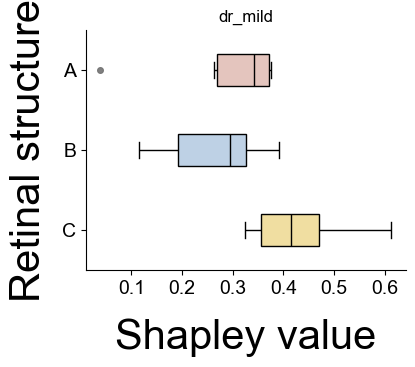

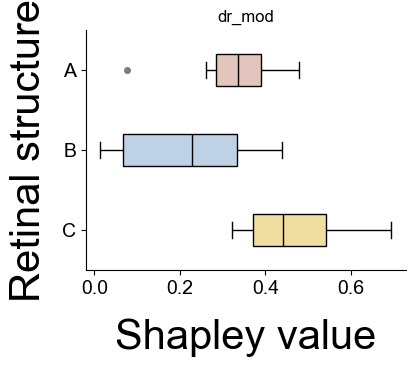

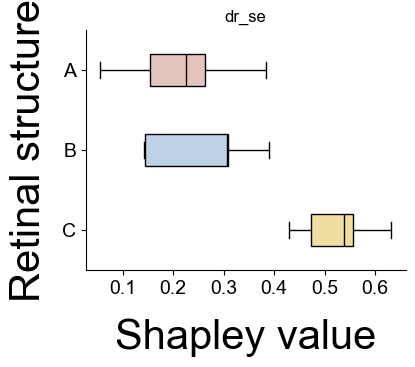

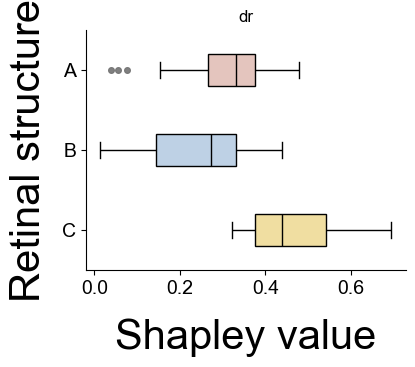

HF_shapely_value_val1_v2.csv


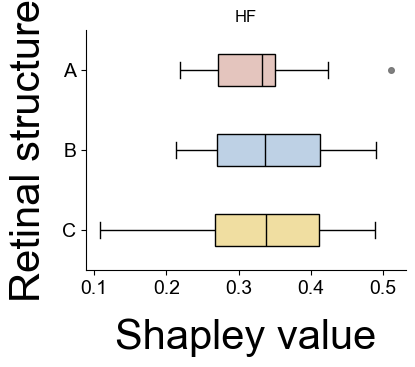

hr_shapley_value.csv


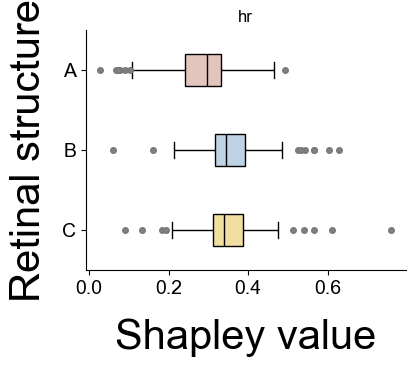

MY_shapely_value_val_1.csv


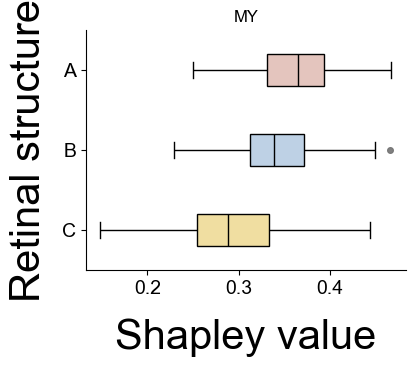

In [17]:
plt.rcParams['font.family'] = 'Arial'
# 读取CSV文件
loaded_data = np.load("reproduction/source/box_shapley.npz", allow_pickle=True)
for file in loaded_data:
    # file_path = r'D:\work\box_tran'
    # file_name = 'hr_shapley_value.csv'
    # read_file = os.path.join(file_path, file_name)
    print(file)
    if file.startswith('dr'):
        df = pd.DataFrame(loaded_data[file])
        # print(df)
        df.columns = [' ', 'name', 'grade', 'Artery', 'Vein', 'Non-vessel', ' ']
        # df = df.astype(str)
        # print(df)
        df_se = df[df['grade'] == 'se']
        df_mild = df[df['grade'] == 'mild']
        df_mod = df[df['grade'] == 'mod']
    # df.columns = ["Artery", "Vein", "Non-vessel"]
    # df = pd.read_csv(read_file, usecols=["Artery", "Vein", "Non-vessel"])
        # df_long = pd.melt(df, var_name="class", value_name="val")
        for id in range(4):
            if id == 0:
                df_mild = df_mild.iloc[:, 3:6]
                tt = 'dr_mild'
                # print(df_mild)
                df_long = pd.melt(df_mild, var_name="class", value_name="val")
            elif id == 1:
                df_mod = df_mod.iloc[:, 3:6]
                tt = 'dr_mod'
                df_long = pd.melt(df_mod, var_name="class", value_name="val")
            elif id == 2:
                df_se = df_se.iloc[:, 3:6]
                tt = 'dr_se'
                df_long = pd.melt(df_se, var_name="class", value_name="val")
            else:
                df = df.iloc[:, 3:6]
                tt = 'dr'
                df_long = pd.melt(df, var_name="class", value_name="val")
            # print(df_long)
            # 设置图形风格
            # sns.set(style="white")
            color1 = ['#da7f6f', '#76a3ce', '#f9bf33']
            color2 = ['#ebc1b7', '#b8d1eb', '#fde594']
            # 绘制箱线图
            fig = plt.figure(figsize=(4, 3))
            # 创建子图，控制图片的位置和大小（参数分别表示左、下、宽度、高度）
            ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])  # 图片在画布中的位置和大小
            # 绘制箱线图，设置箱子的宽度，线条颜色为黑色
            # sns.boxplot(x="值", y="类别", data=df_long, orient="h")
            plt.rcParams['text.color'] = 'black'
            plt.rcParams['axes.labelcolor'] = 'black'
            plt.rcParams['xtick.color'] = 'black'
            plt.rcParams['ytick.color'] = 'black'
            flierprops = dict(marker='o', markerfacecolor='gray', markersize=4, linestyle='none')
            # print(df_long.head())
            sns.boxplot(
                x='val',
                y='class',
                data=df_long,
                hue='class',
                palette=color2,
                linewidth=1,
                orient="h",
                width=0.4,
                ax=ax,
                flierprops=flierprops,
                boxprops=dict(edgecolor="black"),      # 箱子的线条颜色
                whiskerprops=dict(color="black"),  # 胡须的线条颜色
                capprops=dict(color="black"),      # 边缘线的颜色
                medianprops=dict(color="black")    # 中位数线的颜色
            )
            # 设置左边框和底部框线为黑色
            # 添加方括号的上部
            # plt.plot([loc, 3], [1.05, 1.05], lw=1, color='k')

            # 添加p值到图中
            # P = min(p_value)
            # plt.text((loc + 3) * 0.5, 1.065, r'$\it{P}$ < 0.001', ha='center', va='bottom', color='k', fontsize='12')
            ax = plt.gca()  # 获取当前的坐标轴
            ax.spines['left'].set_color('black')
            ax.spines['bottom'].set_color('black')
            # 隐藏右边框和顶部框线
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            # 设置标题和标签
            # tt = file + str(id)
            plt.title(tt)
            plt.xlabel('Shapley value', fontsize=30, labelpad=15)
            plt.ylabel('Retinal structure', fontsize=30, labelpad=10)
            # plt.ylabel('Rate')
            plt.grid(False)
            plt.yticks(ticks=range(3), labels=['A', 'B', 'C'], fontsize=14)
            plt.xticks(fontsize=14)
            # plt.ylim(-0.1, 1.1)

            folder_path2 = r'../result'
            out_name = file.split('.')[0] + str(id) + '.svg'
            out_path = os.path.join(folder_path2, out_name)
            #plt.savefig(out_path, format='svg')
            # 显示图形
            plt.show()
    else:
        df = pd.DataFrame(loaded_data[file])
        # print(df)
        tt = file.split('_')[0]
        df.columns = [' ', 'name', 'Artery', 'Vein', 'Non-vessel']
        df = df.iloc[:, -3:]
        df_long = pd.melt(df, var_name="class", value_name="val")

        # 设置图形风格
        # sns.set(style="white")
        color1 = ['#da7f6f', '#76a3ce', '#f9bf33']
        color2 = ['#ebc1b7', '#b8d1eb', '#fde594']
        # 绘制箱线图
        fig = plt.figure(figsize=(4, 3))
        # 创建子图，控制图片的位置和大小（参数分别表示左、下、宽度、高度）
        ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])  # 图片在画布中的位置和大小
        # 绘制箱线图，设置箱子的宽度，线条颜色为黑色
        # sns.boxplot(x="值", y="类别", data=df_long, orient="h")
        plt.rcParams['text.color'] = 'black'
        plt.rcParams['axes.labelcolor'] = 'black'
        plt.rcParams['xtick.color'] = 'black'
        plt.rcParams['ytick.color'] = 'black'
        flierprops = dict(marker='o', markerfacecolor='gray', markersize=4, linestyle='none')
        # print(df_long.head())
        sns.boxplot(
            x='val',
            y='class',
            data=df_long,
            hue='class',
            palette=color2,
            linewidth=1,
            orient="h",
            width=0.4,
            ax=ax,
            flierprops=flierprops,
            boxprops=dict(edgecolor="black"),  # 箱子的线条颜色
            whiskerprops=dict(color="black"),  # 胡须的线条颜色
            capprops=dict(color="black"),  # 边缘线的颜色
            medianprops=dict(color="black")  # 中位数线的颜色
        )
        # 设置左边框和底部框线为黑色
        # 添加方括号的上部
        # plt.plot([loc, 3], [1.05, 1.05], lw=1, color='k')

        # 添加p值到图中
        # P = min(p_value)
        # plt.text((loc + 3) * 0.5, 1.065, r'$\it{P}$ < 0.001', ha='center', va='bottom', color='k', fontsize='12')
        ax = plt.gca()  # 获取当前的坐标轴
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        # 隐藏右边框和顶部框线
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # 设置标题和标签
        plt.title(tt)
        plt.xlabel('Shapley value', fontsize=30, labelpad=15)
        plt.ylabel('Retinal structure', fontsize=30, labelpad=10)
        # plt.ylabel('Rate')
        plt.grid(False)
        plt.yticks(ticks=range(3), labels=['A', 'B', 'C'], fontsize=14)
        plt.xticks(fontsize=14)
        # plt.ylim(-0.1, 1.1)

        folder_path2 = r'../result'
        out_name = file.split('.')[0] + '.svg'
        out_path = os.path.join(folder_path2, out_name)
        #plt.savefig(out_path, format='svg')
        # 显示图形
        plt.show()